In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_curve, auc, roc_auc_score
import lightgbm as lgb

import gc

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load Data

file_name = "./data/train_preprocessed2.csv"
train_df = pd.read_csv(file_name, low_memory = False)

train_df.head()

,A..papers,A.papers,B.papers,C.papers,Dif.countries,Perc_non_australian,Number.people,PHD,Max.years.univ,Grants.succ,...,SEO.11,SEO.12,SEO.13,SEO.14,SEO.15,SEO.16,SEO.17,SEO.18,SEO.19,Grant.Status
0,4.0,2.0,0.0,0.0,1,0.00,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,6.0,12.0,2.0,2.0,1,1.00,1,1.0,20.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,7.0,20.0,20.0,7.0,2,0.75,4,2.0,50.0,0.0,...,0,0,2,0,0,0,0,0,0,1
3,0.0,3.0,13.0,3.0,1,1.00,2,2.0,15.0,0.0,...,0,0,2,0,0,0,0,0,0,1
4,3.0,0.0,1.0,0.0,1,0.00,1,1.0,10.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [4]:
#Setup data : Divide Test and Train set

array = train_df.values

data = array[:, 0:70]
target = array[:, 70]

data, target

seed = 7
test_size = 0.2

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = test_size, random_state = seed)


In [5]:
min_child_weightP = np.zeros(30)
max_depthP = np.zeros(30)
gammaP = np.zeros(30)
subsampleP = np.zeros(30)
colsample_bytreeP = np.zeros(30)
aucP = np.zeros(30)
cnt = 0

In [6]:
# Making a XGB Train Model Function

def XGB_Train_Model_using_KFold(min_child_weight, max_depth, gamma, subsample,  colsample_bytree) : 
    xgb_params = {
        'n_trees' : 250,
        'eta' : 0.2,
        'max_depth' : int(max_depth),
        'subsample' : max(min(subsample, 1), 0),
        'objective' : 'reg:linear', 
        'base_score' : np.mean(target),
        'eval_metric' : 'auc',
        'silent' : 1,
        'min_child_weight' : int(min_child_weight),
        'gamma' : max(gamma, 0), 
        'colsample_bytree' : max(min(colsample_bytree, 1), 0)
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    
    #n_splits = int(max(n_splits_param, 2))
    kfold = KFold(n_splits = 5, random_state = 7)
    results = cross_val_score(model, data, target, cv = kfold)
    accuracy = results.mean()*100
    print("Accuracy : %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    global min_child_weightP 
    global max_depthP 
    global gammaP 
    global subsampleP
    global colsample_bytreeP
    global aucP
    global cnt
    
    min_child_weightP[cnt] = min_child_weight
    max_depthP[cnt] = max_depth
    gammaP[cnt] = gamma
    subsampleP[cnt] = subsample
    colsample_bytreeP[cnt] = colsample_bytree
    aucP[cnt] = accuracy
    cnt += 1
    
    return accuracy

In [7]:
xgb_params = {
    
    #Learning Rate  -> not needed, doesn't change result in range (0.01, 0.2)
    #'eta' : (0.01, 0.2),
    
    #Minimum sum of weights : to control overfitting
    'min_child_weight' : (1, 20), 
    
    #Maximum depth of a tree : to control overfitting
    'max_depth' : (2, 10),
    
    #minimum loss reduction required to make a split : makes algorithm conservative
    'gamma' : (0, 10), 
    
    #max_delta_step is not needed since data is not imbalanced
    #'max_delta_step' : (0, 10),
    
    #Fraction of observations to be randomly samples for each tree
    #Lower: prevent overfitting
    'subsample' : (0.5, 1),
    
    #Fraction of columns to be randomly samples for each tree
    'colsample_bytree' : (0.1, 1),
    
    #colsamble_bylevel is not needed since subsample and colsample_bytree will do the job
    #'colsample_bylevel' = (0.1, 1),
    
    #L2 regularization term on weights
    #'lambda' = (?, ?)
    
    #L1 regularization term on weight
    #'alpha' = (?, ?)
    
    #scale_pos_weight is not needed since data is not imbalanced
    #'scale_pos_weight' = (0, 10)
    #'n_splits_param' : (5, 10)
}


xgb_bayesOPT = BayesianOptimization(XGB_Train_Model_using_KFold, xgb_params)
xgb_bayesOPT.maximize(init_points = 5, n_iter = 25)


Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Accuracy : 85.35% (3.26%)
    1 | 00m04s |   85.34750 |             0.5353 |    1.9131 |      5.2924 |            12.1919 |      0.8265 | 
Accuracy : 82.04% (6.00%)
    2 | 00m10s |   82.04069 |             0.8906 |    5.6986 |      7.0824 |            12.6634 |      0.6794 | 
Accuracy : 84.47% (3.92%)
    3 | 00m09s |   84.47485 |             0.7808 |    1.4148 |      8.4736 |            14.7645 |      0.7376 | 
Accuracy : 85.01% (3.37%)
    4 | 00m05s |   85.01454 |             0.5908 |    3.3738 |      6.2303 |            17.8317 |      0.7821 | 
Accuracy : 82.47% (5.63%)
    5 | 00m06s |   82.46550 |             0.6435 |    8.9524 |      8.5378 |             9.9018 |      0.9437 | 
Bayesian Optimization
-------------------------------------------

In [8]:
min_child_weightP 


array([12.19185256, 12.663407  , 14.76448228, 17.83169949,  9.90178081,
       15.78313136, 14.85164767, 11.17664729, 17.28712267, 12.44574717,
       11.63805455, 16.50346333, 11.65078956, 10.25807271, 16.89471894,
       17.50679108, 14.51783716, 11.72618225, 11.79511086, 12.87358947,
       14.46514514, 12.19886246, 12.47938168, 10.68175769, 13.56488232,
       17.50278205, 17.50895867, 15.45005996, 14.94908907, 11.63907603])

In [9]:
max_depthP 


array([5.29242912, 7.08241626, 8.47355485, 6.23030851, 8.53775957,
       5.33684503, 6.81007964, 6.63313586, 7.23122354, 6.70298364,
       5.6461165 , 5.80628135, 5.31113183, 8.35934905, 6.06898314,
       6.72479016, 6.66822879, 5.30642145, 5.75646885, 5.0656575 ,
       8.04492148, 5.57932924, 4.55097235, 6.53773925, 5.1635811 ,
       6.15698062, 6.35145087, 7.46842724, 5.60281995, 6.79572028])

In [10]:
aucP
aucP = aucP /100

In [11]:
aucP

array([0.85347501, 0.82040693, 0.84474849, 0.85014544, 0.82465499,
       0.82923792, 0.84865304, 0.85198083, 0.83923686, 0.83532552,
       0.84337056, 0.84325628, 0.85186661, 0.83234631, 0.84061564,
       0.83670285, 0.84647045, 0.83682208, 0.84819294, 0.85232612,
       0.83935259, 0.84876706, 0.84899839, 0.84819412, 0.853476  ,
       0.84302534, 0.82706766, 0.85244198, 0.8477335 , 0.85209788])

In [12]:
'''
'min_child_weight' : (1, 20), 
'max_depth' : (2, 10),
'gamma' : (0, 10), 
'subsample' : (0.5, 1),
'colsample_bytree' : (0.1, 1),
    
''' 


"\n'min_child_weight' : (1, 20), \n'max_depth' : (2, 10),\n'gamma' : (0, 10), \n'subsample' : (0.5, 1),\n'colsample_bytree' : (0.1, 1),\n    \n"

In [13]:
min_child_weightP = (min_child_weightP - 1) / 20
max_depthP = (max_depthP - 2) / 8
gammaP = gammaP / 10
subsampleP = (subsampleP - 0.5) / 0.5
colsample_bytreeP = (colsample_bytreeP - 0.1) / 0.9

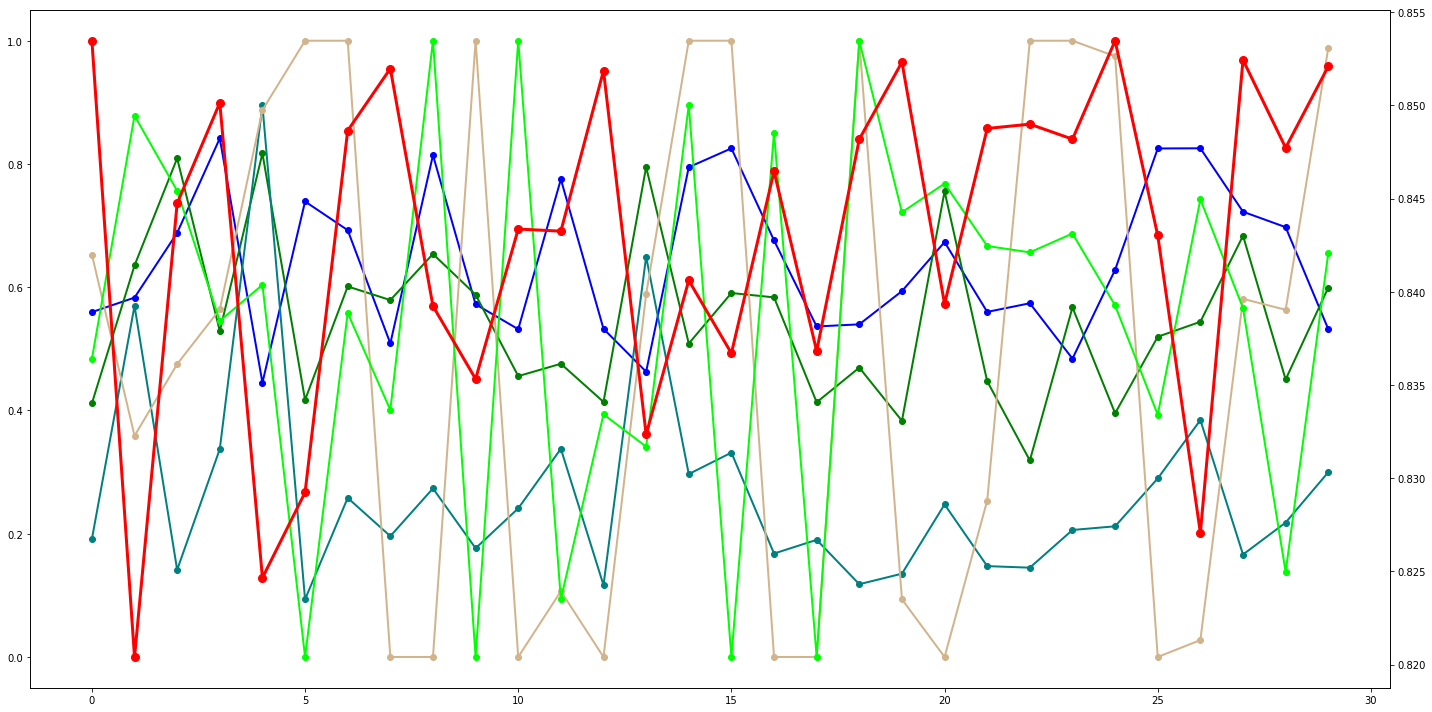

In [22]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'step' : np.arange(30), 'min_child_weight' : min_child_weightP, 'max_depth' : max_depthP, 'gamma' : gammaP, 'subsample' : subsampleP, 'colsample_bytree' : colsample_bytreeP, 'auc' : aucP})

fig, ax1 = plt.subplots(figsize = (20,10))

ax1.plot( 'step', 'min_child_weight', data=df, marker='o', color='blue', linewidth=2, label = 'min_child_weight')
ax1.plot( 'step', 'max_depth', data = df, marker = 'o', color = 'green', linewidth = 2, label = 'max_depth')
ax1.plot( 'step', 'gamma', data = df, marker = 'o', color = 'teal', linewidth = 2, label = 'gamma')
ax1.plot( 'step', 'subsample', data = df, marker = 'o', color = 'tan', linewidth = 2, label = 'subsample')
ax1.plot( 'step', 'colsample_bytree', data = df, marker = 'o', color = 'lime', linewidth = 2, label = 'colsample_bytree')

ax2 = ax1.twinx()
ax2.plot( 'step', 'auc', data = df, marker = 'o', color = 'red', markersize = 8, linewidth = 3, label = 'auc')

fig.tight_layout()

plt.show()